## Implementasi Metode VADER-LSTM dalam Pengujian Pengaruh Sentimen Investor terhadap Prediksi Harga Saham

In [1]:
import math
import nltk
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
company = "TSLA"

In [3]:
all_tweets = pd.read_csv("stock_tweets.csv")
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [4]:
tweet_df = all_tweets[all_tweets['Stock Name'] == company]
tweet_df = tweet_df.drop('Company Name', axis=1)
tweet_df['Date'] = pd.to_datetime(tweet_df['Date'])
tweet_df['Date'] = tweet_df['Date'].dt.date
print(tweet_df.shape)
tweet_df.head()

(37422, 3)


,Date,Tweet,Stock Name
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA


In [5]:
sentiment_df = tweet_df.copy()
sentiment_df["Negative"] = pd.Series(dtype='float64')
sentiment_df["Neutral"] = pd.Series(dtype='float64')
sentiment_df["Positive"] = pd.Series(dtype='float64')
sentiment_df["Compound"] = pd.Series(dtype='float64')
sentiment_df.head()

,Date,Tweet,Stock Name,Negative,Neutral,Positive,Compound
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,NaN,NaN,NaN,NaN
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,NaN,NaN,NaN,NaN
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,NaN,NaN,NaN,NaN
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,NaN,NaN,NaN,NaN
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,NaN,NaN,NaN,NaN


In [6]:
%%time
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sentiment_df.T.items():
    try:
        sentence_i = unicodedata.normalize('NFKD', sentiment_df.loc[indx, 'Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sentiment_df.at[indx, 'Compound'] = sentence_sentiment['compound']
        sentiment_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sentiment_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sentiment_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (sentiment_df.loc[indx, 'Tweet'])
        print (indx)
        break

CPU times: total: 8.08 s
Wall time: 41.9 s


In [7]:
sentiment_df.head()

,Date,Tweet,Stock Name,Negative,Neutral,Positive,Compound
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,0.127,0.758,0.115,0.0772
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,0.000,1.000,0.000,0.0000
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,0.000,0.951,0.049,0.2960
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,0.273,0.590,0.137,-0.7568
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,0.526,0.474,0.000,-0.8750


In [8]:
sentiment_df.drop(['Negative', 'Positive', 'Neutral', 'Stock Name'], axis=1, inplace=True)
sentiment_df.head()

,Date,Tweet,Compound
0,2022-09-29,Mainstream media has done an amazing job at br...,0.0772
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,0.0000
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,0.2960
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,-0.7568
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",-0.8750


In [9]:
daily_sentiments_df = sentiment_df.groupby([sentiment_df['Date']]).mean(numeric_only=True)
daily_sentiments_df.head()

,Compound
Date,
2021-09-30,0.231552
2021-10-01,0.233704
2021-10-02,0.271940
2021-10-03,0.271570
2021-10-04,0.135388


In [11]:
daily_sentiments_df.dtypes

Compound    float64
dtype: object

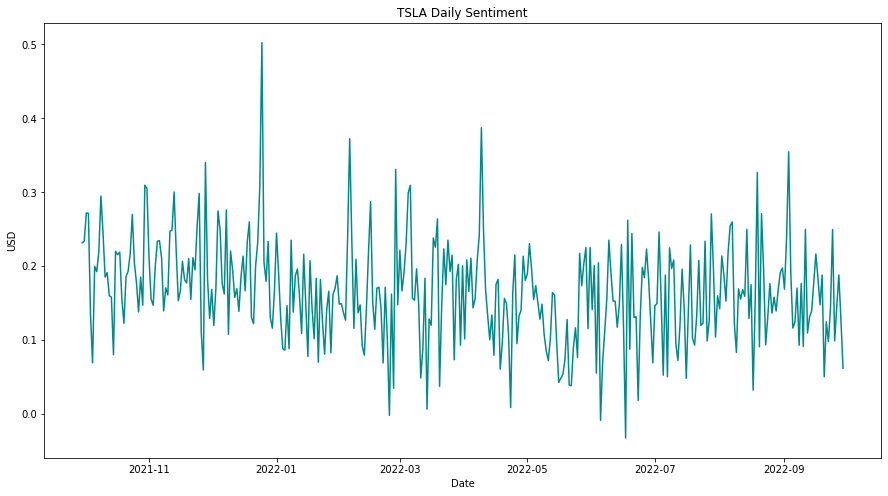

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(daily_sentiments_df['Compound'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{company} Daily Sentiment")
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

In [11]:
all_stocks = pd.read_csv("stock_yfinance_data.csv")
all_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [12]:
stock_df = all_stocks[all_stocks['Stock Name'] == company]
stock_df = stock_df.drop('Stock Name', axis=1)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date
stock_df = stock_df.set_index("Date")
print(stock_df.shape)
stock_df.head()

(252, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400


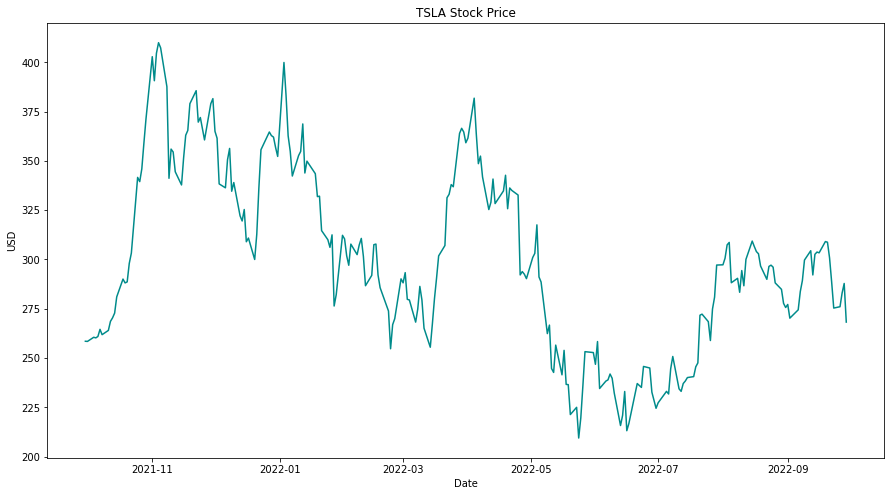

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(stock_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{company} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.show()

In [14]:
dataset_df = stock_df.copy()
dataset_df = dataset_df.join(daily_sentiments_df, how="left", on="Date")
print(dataset_df.shape)
dataset_df.head()

(252, 7)


,Open,High,Low,Close,Adj Close,Volume,Compound
Date,,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.231552
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.233704
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.135388
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.069445
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.199940


### The Model

In [15]:
def trainModel(x_data, y_data, epoch):

    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_data.shape[1], x_data.shape[2])))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_data, y_data, batch_size= 1, epochs=epoch)

    return model

#### LSTM Only

In [16]:
close_prices = dataset_df['Close']
stock_values = close_prices.values

train_portion = 0.7
timestep = 60

training_data_len = math.ceil(len(stock_values)* train_portion)

scaler = MinMaxScaler(feature_range=(0,1))
stock_data_scaled = scaler.fit_transform(stock_values.reshape(-1,1))

In [17]:
train_data = stock_data_scaled[0: training_data_len, :]

x_train = []
y_train = []

for i in range(timestep, len(train_data)):
    x_train.append(train_data[i-timestep:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [18]:
test_data = stock_data_scaled[training_data_len-60: , : ]
x_test = []
y_test = stock_values[training_data_len:]

for i in range(timestep, len(test_data)):
  x_test.append(test_data[i-timestep:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
singleModel = trainModel(x_train, y_train, 20)

Epoch 1/20
117/117 [==============================] - 15s 41ms/step - loss: 0.0253
Epoch 2/20
117/117 [==============================] - 5s 38ms/step - loss: 0.0110
Epoch 3/20
117/117 [==============================] - 5s 40ms/step - loss: 0.0105
Epoch 4/20
117/117 [==============================] - 4s 37ms/step - loss: 0.0104
Epoch 5/20
117/117 [==============================] - 5s 40ms/step - loss: 0.0085
Epoch 6/20
117/117 [==============================] - 6s 52ms/step - loss: 0.0084
Epoch 7/20
117/117 [==============================] - 5s 42ms/step - loss: 0.0071
Epoch 8/20
117/117 [==============================] - 11s 91ms/step - loss: 0.0067
Epoch 9/20
117/117 [==============================] - 15s 130ms/step - loss: 0.0087
Epoch 10/20
117/117 [==============================] - 9s 77ms/step - loss: 0.0066
Epoch 11/20
117/117 [==============================] - 10s 89ms/step - loss: 0.0056
Epoch 12/20
117/117 [==============================] - 8s 64ms/step - loss: 0.0069
Epoch 13

In [20]:
predictions = singleModel.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3/3 [==============================] - 3s 41ms/step


3.5973370361328123

C:\Users\ravie\AppData\Local\Temp\ipykernel_19320\2833513373.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


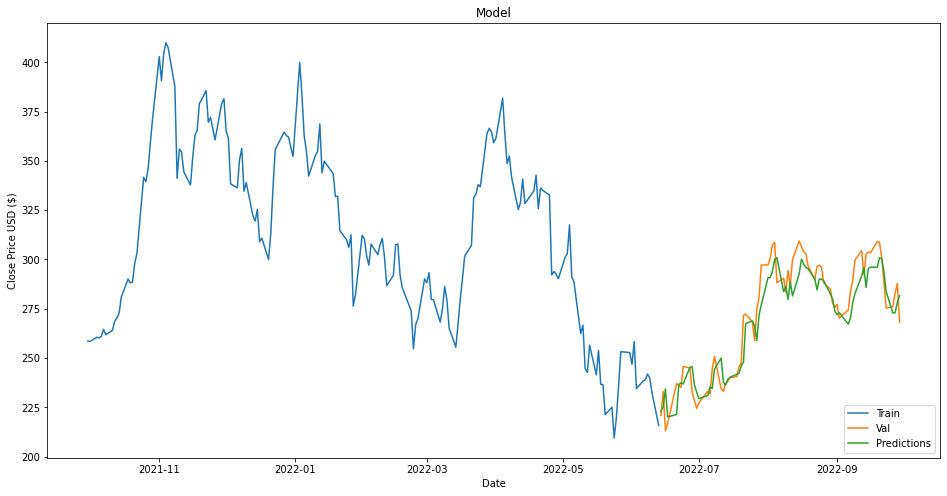

In [21]:
data = dataset_df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# LSTM with User Sentiment Score

In [22]:
combined_data = dataset_df[['Close', 'Compound']].copy()
combined_values = combined_data.values

close_prices = dataset_df['Close']
stock_values = close_prices.values

train_portion = 0.7
timestep = 60

training_data_len = math.ceil(len(combined_values)* train_portion)

scaler = MinMaxScaler(feature_range=(0,1))
combined_data_scaled_x = scaler.fit_transform(combined_values)
combined_data_scaled_y = scaler.fit_transform(stock_values.reshape(-1,1))

In [23]:
train_data_x = combined_data_scaled_x[0: training_data_len, :]
train_data_y = combined_data_scaled_y[0: training_data_len, :]

x_train = []
y_train = []

for i in range(timestep, len(train_data_x)):
    x_train.append(train_data_x[i-timestep:i])
    y_train.append(train_data_y[i][0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

In [24]:
test_data = combined_data_scaled_x[training_data_len-timestep: , : ]
x_test = []
y_test = stock_values[training_data_len:]

for i in range(timestep, len(test_data)):
  x_test.append(test_data[i-timestep:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [25]:
sentimentModel = trainModel(x_train, y_train, 20)

Epoch 1/20
117/117 [==============================] - 14s 40ms/step - loss: 0.0331
Epoch 2/20
117/117 [==============================] - 4s 38ms/step - loss: 0.0160
Epoch 3/20
117/117 [==============================] - 8s 68ms/step - loss: 0.0115
Epoch 4/20
117/117 [==============================] - 5s 46ms/step - loss: 0.0095
Epoch 5/20
117/117 [==============================] - 7s 60ms/step - loss: 0.0102
Epoch 6/20
117/117 [==============================] - 6s 54ms/step - loss: 0.0116
Epoch 7/20
117/117 [==============================] - 5s 42ms/step - loss: 0.0086
Epoch 8/20
117/117 [==============================] - 5s 44ms/step - loss: 0.0075
Epoch 9/20
117/117 [==============================] - 5s 47ms/step - loss: 0.0098
Epoch 10/20
117/117 [==============================] - 9s 81ms/step - loss: 0.0082
Epoch 11/20
117/117 [==============================] - 11s 96ms/step - loss: 0.0072
Epoch 12/20
117/117 [==============================] - 6s 52ms/step - loss: 0.0057
Epoch 13/20

In [26]:
predictions = sentimentModel.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3/3 [==============================] - 2s 32ms/step


4.696616617838542

C:\Users\ravie\AppData\Local\Temp\ipykernel_19320\2833513373.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


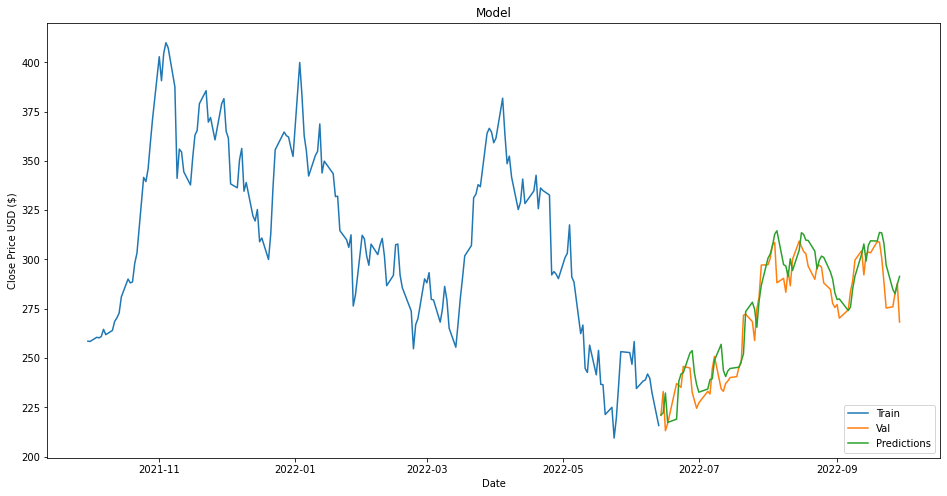

In [27]:
data = dataset_df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()